In [27]:
import numpy as np
import pandas as pd
# lightgbm
import lightgbm as lgb
import warnings
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# import data

In [17]:
data = pd.read_excel('./AML and ATF Modelling Assignment data_std_Updated.xlsx', sheet_name='data')

In [22]:
data_dictionary = pd.read_excel('./AML and ATF Modelling Assignment data_std_Updated.xlsx', sheet_name='data dictionary')

# Data EDA

In [24]:
data_dictionary

,Type,Data Element,Description
0,ID,cust_id_masked,Unique Customer ID
1,Target,rating,"Ratings (1 - high risk, 0 - moderate or low risk)"
2,Feature,cust_tenure,Number of years the customer has been with Sco...
3,Feature,cust_cdn_resident,Binary indicator whether the customer resides ...
4,Feature,prod_sav,Binary indicator for savings account
...,...,...,...
146,Feature,tot_cash_val_5m,Total amount of cash transaction (withdrawal a...
147,Feature,tot_cross_border_cnt_12m,Total count of cross-border wire transaction (...
148,Feature,tot_cash_cnt_5m,Total count of cash transaction (withdrawal an...
149,Feature,avg_cash_5m,Average of cash transaction (withdrawal and de...


In [19]:
data['rating'].value_counts()

rating
0    390
1    198
Name: count, dtype: int64

In [20]:
data['cust_id_masked'].unique()# the number of unique customers = num of rows, we can safely drop this column as it is not useful

array(['004f8eab603ba30ea8fffd64ef39d5a990aff66b35f447150a2c09e54566b2ba',
       '00a38e35a8350be0d0d2ef2c7c40de54f049ff8359b54ed72452496f8bdeec93',
       '00d442a125b121bcd9e17ae58fdce2e7ae3513375afb2a08c1014d50d7074933',
       '0114b5ce76aa3c09c460620cc19f1a77087ede3c326021c4ad59d2fe49abb825',
       '015a0ba1cb86c4e46bb01f8ed501254cfb7422e240583f2e643a80ef97368ef5',
       '02f72cff71eeda1faaee79504b187db91491a12a62a5ab3a6288e6af27d124a7',
       '036f4bd2a05492d4c1f607b5cec9d831d9584ca69715e9cbe25a5a5c0090a8c3',
       '03d5fc5a8f1cf8b937916b12a5e9b5351200eaf8af8d44943e0a3d66e111438c',
       '03ec6ee67c63b7a5102dc8720742194894aaf5f8f327b92108e42fdb9f84e422',
       '04adacd9e573d85f5eec6b907d1a30b0d9e964a4faa037d188a68428a207b868',
       '0574ed27d7c7a504496fcabf1e20061bfafc1e8e2ecbc280d3cf4c78500c2241',
       '05a5fb44fc52346be364bb991df22dc9f1ae94a55ce6986c8f46a631b86b6f70',
       '063f640cd7552ee9b28b8346af39d7c2a755ebc764323a821784508f44ac2361',
       '06bb3c1535f6fb8f6

med doesn't contain too much information so we discard it, and dimension reduce to only high risk and low risk, same as what the target did. also we notice geo domicile risk is the same as the geo mail risk, so we can discard it as well 

In [106]:
mutual_info_classif(data.loc[:,['geo_mail_addr_country_rate_high','geo_mail_addr_country_rate_low','geo_mail_addr_country_rate_med']], data['rating'], discrete_features=True)

array([0.02405594, 0.02282895, 0.00038627])

In [107]:
mutual_info_classif(data.loc[:,['geo_domicile_country_rate_high','geo_domicile_country_rate_low','geo_domicile_country_rate_med']], data['rating'], discrete_features=True)

array([0.02405594, 0.02282895, 0.00038627])

In [109]:
data['geo_mail_addr_country_rate_high'].corr(data['geo_domicile_country_rate_high'])

1.0

In [111]:
data['geo_mail_addr_country_rate_high'].corr(data['geo_mail_addr_country_rate_low'])

-0.9251724928930445

In [112]:
data['geo_domicile_country_rate_high'].corr(data['geo_domicile_country_rate_low'])

-0.9251724928930445

30-49 cash related

In [154]:
data.columns

Index(['cust_tenure', 'cust_cdn_resident', 'prod_sav', 'prod_primary_sav_cnt',
       'prod_cda', 'prod_primary_cda_cnt', 'prod_mor', 'prod_primary_mor_cnt',
       'prod_llc', 'prod_primary_llc_cnt',
       ...
       'max_acct_num', 'acct_type_num', 'tot_acct_num.1',
       'tot_cross_border_val_12m', 'tot_cash_val_5m',
       'tot_cross_border_cnt_12m', 'tot_cash_cnt_5m', 'avg_cash_5m',
       'avg_wire_12m', 'rating'],
      dtype='object', length=146)

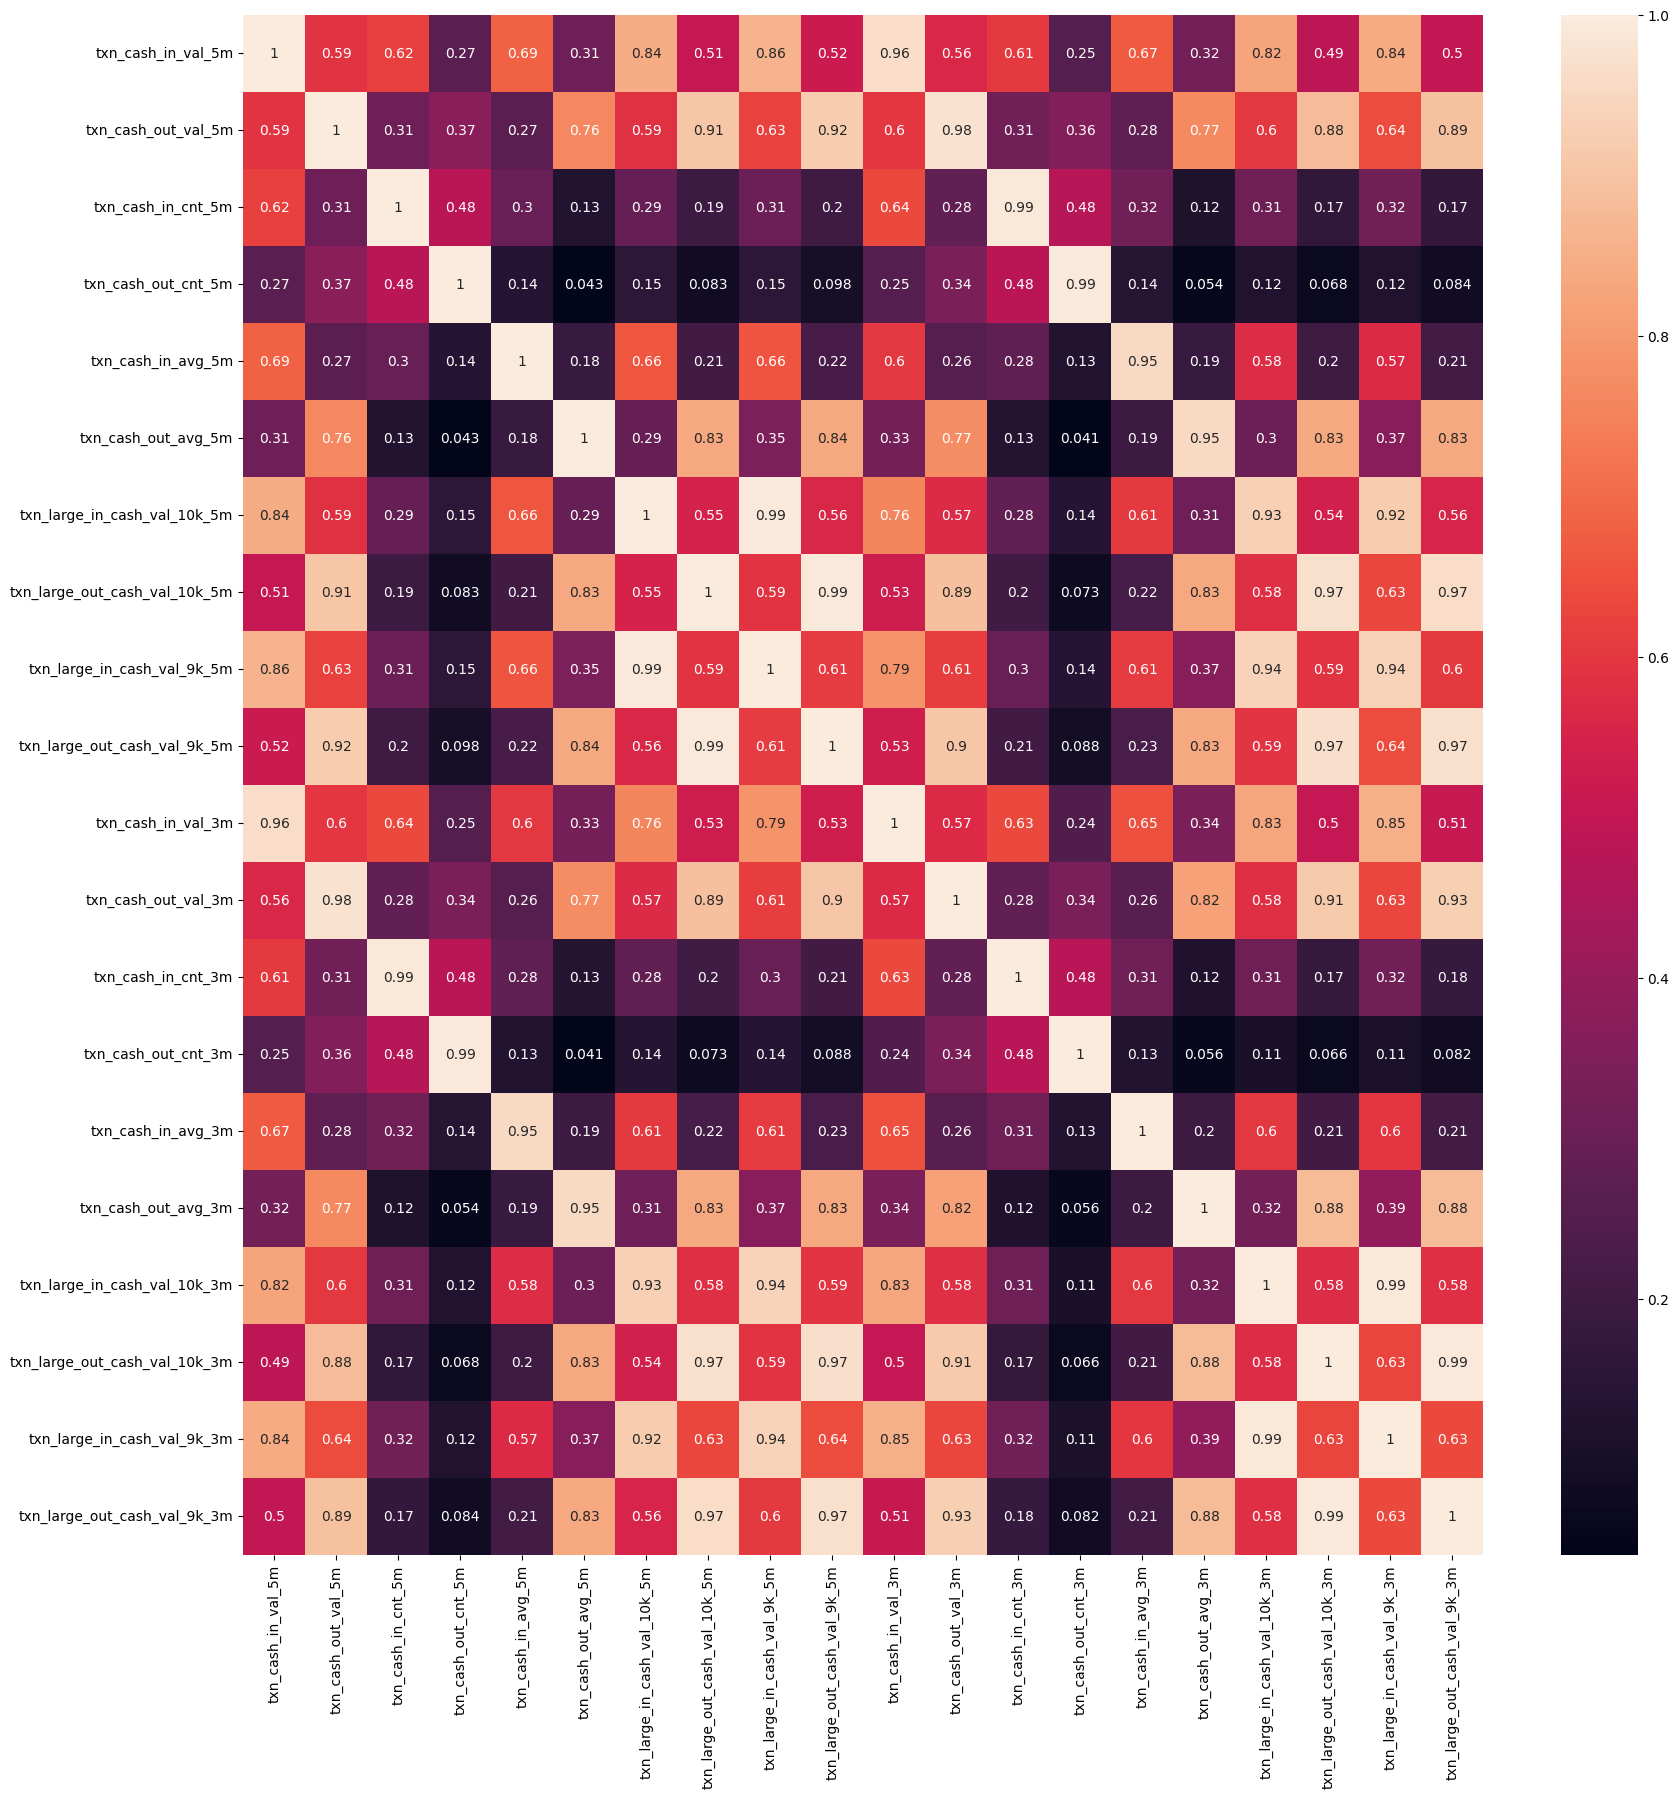

In [157]:
#plot heatmap for cash related columns
import seaborn as sns
plt.figure(figsize=(20,20))
sns.heatmap(data.iloc[:,24:44].corr(), annot=True)
plt.show()

notice the pattern that the 5month and 3 month data are more or less the same, so from a time perspective, we can keep 3month data 

dropping data columns that are not useful

In [113]:
data = data.drop(columns=['geo_mail_addr_country_rate_med','geo_domicile_country_rate_med','geo_domicile_country_rate_high','geo_domicile_country_rate_low','geo_mail_addr_country_rate_low','cust_id_masked'])

# Feature Engineering 

In [144]:
possible_feature = pd.DataFrame()
possible_feature['complete_account']=data['prod_sav']*data['prod_cda']*data['prod_crc']
possible_feature['asset_liability_imbalance']=(data['prod_asset_balance']-data['prod_liability_balance'])/(data['prod_asset_balance']+data['prod_liability_balance'])
possible_feature['primary_account_imbalance']=(data['prod_prim_acct_cnt']-data['prod_none_prim_acct_cnt'])/(data['prod_prim_acct_cnt']+data['prod_none_prim_acct_cnt'])
possible_feature['canceled_account']=1-(data['prod_none_prim_acct_cnt']+data['prod_prim_acct_cnt'])/data['prod_total_acct_cnt']
possible_feature['net_10k_avoid_mark']=(data['txn_large_in_cash_val_10k_5m']-data['txn_large_out_cash_val_10k_5m'])-(data['txn_large_in_cash_val_9k_5m']-data['txn_large_out_cash_val_9k_5m'])

In [145]:
pd.DataFrame(mutual_info_classif(possible_feature, data['rating'], discrete_features=True)).set_index(possible_feature.columns)

,0
complete_account,0.063618
asset_liability_imbalance,0.531657
primary_account_imbalance,0.101496
canceled_account,0.101496
large_in_avoid_mark,0.059455
net_10k_avoid_mark,0.078160


In [146]:
possible_feature.corr()

,complete_account,asset_liability_imbalance,primary_account_imbalance,canceled_account,large_in_avoid_mark,net_10k_avoid_mark
complete_account,1.000000,-0.012132,-0.056627,-0.045850,-0.037529,-0.043836
asset_liability_imbalance,-0.012132,1.000000,0.016756,-0.015864,0.376577,0.301035
primary_account_imbalance,-0.056627,0.016756,1.000000,-0.224721,-0.009347,0.012199
canceled_account,-0.045850,-0.015864,-0.224721,1.000000,0.007672,-0.006800
large_in_avoid_mark,-0.037529,0.376577,-0.009347,0.007672,1.000000,0.762209
net_10k_avoid_mark,-0.043836,0.301035,0.012199,-0.006800,0.762209,1.000000


complete account

In [66]:
temp = data.loc[:,['prod_sav','prod_cda','prod_crc']]
temp['complete_account']=data['prod_sav']*data['prod_cda']*data['prod_crc']
mutual_info_classif(temp, data['rating'], discrete_features=True)

array([0.00914176, 0.04529319, 0.00129574, 0.06361827])

In [67]:
temp.corr()

,prod_sav,prod_cda,prod_crc,complete_account
prod_sav,1.000000,0.401802,0.048833,0.156999
prod_cda,0.401802,1.000000,0.122171,0.020838
prod_crc,0.048833,0.122171,1.000000,0.370716
complete_account,0.156999,0.020838,0.370716,1.000000


asset liability imbalance

In [68]:
temp = data.loc[:,['prod_asset_balance','prod_liability_balance']]
temp['asset_liability_imbalance']=(data['prod_asset_balance']-data['prod_liability_balance'])/(data['prod_asset_balance']+data['prod_liability_balance'])
mutual_info_classif(temp, data['rating'], discrete_features=True)

array([0.41301762, 0.36347236, 0.53165716])

In [69]:
temp.corr()

,prod_asset_balance,prod_liability_balance,asset_liability_imbalance
prod_asset_balance,1.000000,0.008997,0.041988
prod_liability_balance,0.008997,1.000000,-0.041988
asset_liability_imbalance,0.041988,-0.041988,1.000000


primary account imbalance

In [78]:
temp = data.loc[:,['prod_prim_acct_cnt','prod_none_prim_acct_cnt']]
temp['primary_account_imbalance']=(data['prod_prim_acct_cnt']-data['prod_none_prim_acct_cnt'])/(data['prod_prim_acct_cnt']+data['prod_none_prim_acct_cnt'])
mutual_info_classif(temp, data['rating'], discrete_features=True)

array([0.03892661, 0.01163802, 0.10149633])

In [79]:
temp.corr()

,prod_prim_acct_cnt,prod_none_prim_acct_cnt,primary_account_imbalance
prod_prim_acct_cnt,1.000000,0.036419,-0.08693
prod_none_prim_acct_cnt,0.036419,1.000000,0.08693
primary_account_imbalance,-0.086930,0.086930,1.00000


canceled account

In [82]:
temp = data.loc[:,['prod_total_acct_cnt','prod_none_prim_acct_cnt','prod_prim_acct_cnt']]
temp['canceled_account']=1-(data['prod_none_prim_acct_cnt']+data['prod_prim_acct_cnt'])/data['prod_total_acct_cnt']
mutual_info_classif(temp, data['rating'], discrete_features=True)

array([0.04715578, 0.01163802, 0.03892661, 0.10149633])

In [83]:
temp.corr()

,prod_total_acct_cnt,prod_none_prim_acct_cnt,prod_prim_acct_cnt,canceled_account
prod_total_acct_cnt,1.000000e+00,0.483300,0.892475,1.392056e-18
prod_none_prim_acct_cnt,4.833000e-01,1.000000,0.036419,9.635692e-03
prod_prim_acct_cnt,8.924755e-01,0.036419,1.000000,-4.964986e-03
canceled_account,1.392056e-18,0.009636,-0.004965,1.000000e+00


In [35]:
# plot horizontal bar chart of mutual information
info_gain = pd.DataFrame(mutual_info_classif(data.drop(columns=['rating','cust_id_masked']), data['rating'], discrete_features=True), index=data.drop(columns=['rating','cust_id_masked']).columns, columns=['info_gain']).sort_values(by='info_gain', ascending=False)

In [56]:
mutual_info_classif(data.loc[:,['prod_sav','prod_cda','prod_crc']], data['rating'], discrete_features=True)

array([0.00914176, 0.04529319, 0.00129574])

In [39]:
info_gain.describe()

,info_gain
count,150.000000
mean,0.064345
std,0.107214
min,0.000083
25%,0.011560
50%,0.025299
75%,0.050603
max,0.565524


In [38]:
info_gain.loc['cust_cdn_resident']

info_gain    0.020894
Name: cust_cdn_resident, dtype: float64

# Data Preprocessing

In [6]:
# split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['rating','cust_id_masked']), data['rating'], test_size=0.2, stratify=data['rating'], random_state=42)

In [7]:
X_train

,cust_tenure,cust_cdn_resident,prod_sav,prod_primary_sav_cnt,prod_cda,prod_primary_cda_cnt,prod_mor,prod_primary_mor_cnt,prod_llc,prod_primary_llc_cnt,...,prod_med,max_acct_num,acct_type_num,tot_acct_num.1,tot_cross_border_val_12m,tot_cash_val_5m,tot_cross_border_cnt_12m,tot_cash_cnt_5m,avg_cash_5m,avg_wire_12m
292,1.336893,0.231869,1.208408,0.548246,0.842201,0.297862,-0.391077,-0.324689,1.840668,3.161329,...,0.804400,2.694537,1.920015,2.216489,-0.128725,1.034440,-0.291457,2.401794,0.187162,-0.140963
547,-0.655894,0.231869,1.208408,0.548246,0.842201,0.297862,-0.391077,-0.324689,-0.543281,-0.494249,...,0.804400,-0.602150,1.221395,0.115852,-0.107728,-0.247187,1.645004,0.200406,-0.229683,-0.123483
554,-0.435530,-4.312772,-0.827535,-0.677491,0.842201,0.297862,2.557042,1.443063,-0.543281,-0.494249,...,0.804400,-0.602150,-0.175843,-0.484331,0.231009,-0.378492,1.160889,-0.835541,-0.400281,0.258353
538,0.181378,0.231869,1.208408,0.548246,-1.187365,-0.989953,-0.391077,-0.324689,-0.543281,-0.494249,...,-1.243163,-0.602150,-0.874462,-0.784422,-0.128725,-0.130114,-0.291457,0.329900,-0.113431,-0.140963
44,-0.301577,0.231869,-0.827535,-0.677491,0.842201,0.297862,-0.391077,-0.324689,1.840668,1.333540,...,0.804400,1.375862,1.221395,1.016125,-0.128725,-0.378492,-0.291457,-0.835541,-0.400281,-0.140963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,1.185043,0.231869,-0.827535,-0.677491,0.842201,0.297862,-0.391077,-0.324689,-0.543281,-0.494249,...,0.804400,0.057187,-0.175843,-0.184240,-0.128725,-0.365990,-0.291457,-0.058580,-0.378624,-0.140963
201,0.850301,0.231869,-0.827535,-0.677491,0.842201,0.297862,-0.391077,-0.324689,-0.543281,-0.494249,...,0.804400,-0.602150,-0.874462,-0.784422,-0.128725,-0.182187,-0.291457,0.070913,-0.108795,-0.140963
313,1.218321,0.231869,1.208408,1.773983,0.842201,0.297862,-0.391077,-0.324689,-0.543281,-0.494249,...,0.804400,0.057187,-0.175843,-0.184240,-0.128725,-0.083463,-0.291457,-0.706047,2.666267,-0.140963
576,2.128582,0.231869,-0.827535,-0.677491,-1.187365,-0.989953,-0.391077,-0.324689,1.840668,1.333540,...,-1.243163,0.716525,-0.175843,0.115852,-0.128725,-0.208850,-0.291457,-0.706047,1.362984,-0.140963


In [16]:
# run lightgbm feature importance on original data
# create dataset for lightgbm
lgb_train = lgb.Dataset(train.drop(['rating','cust_id_masked'], axis=1), train['rating'])
lgb_eval = lgb.Dataset(test.drop(['rating','cust_id_masked'], axis=1), test['rating'], reference=lgb_train)


In [19]:
# specify your configurations as a dict
params = {
    
}
# train lightgbm
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100,
                valid_sets=lgb_eval,
                )

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2325
[LightGBM] [Info] Number of data points in the train set: 470, number of used features: 92
[LightGBM] [Info] Start training from score 0.348936
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

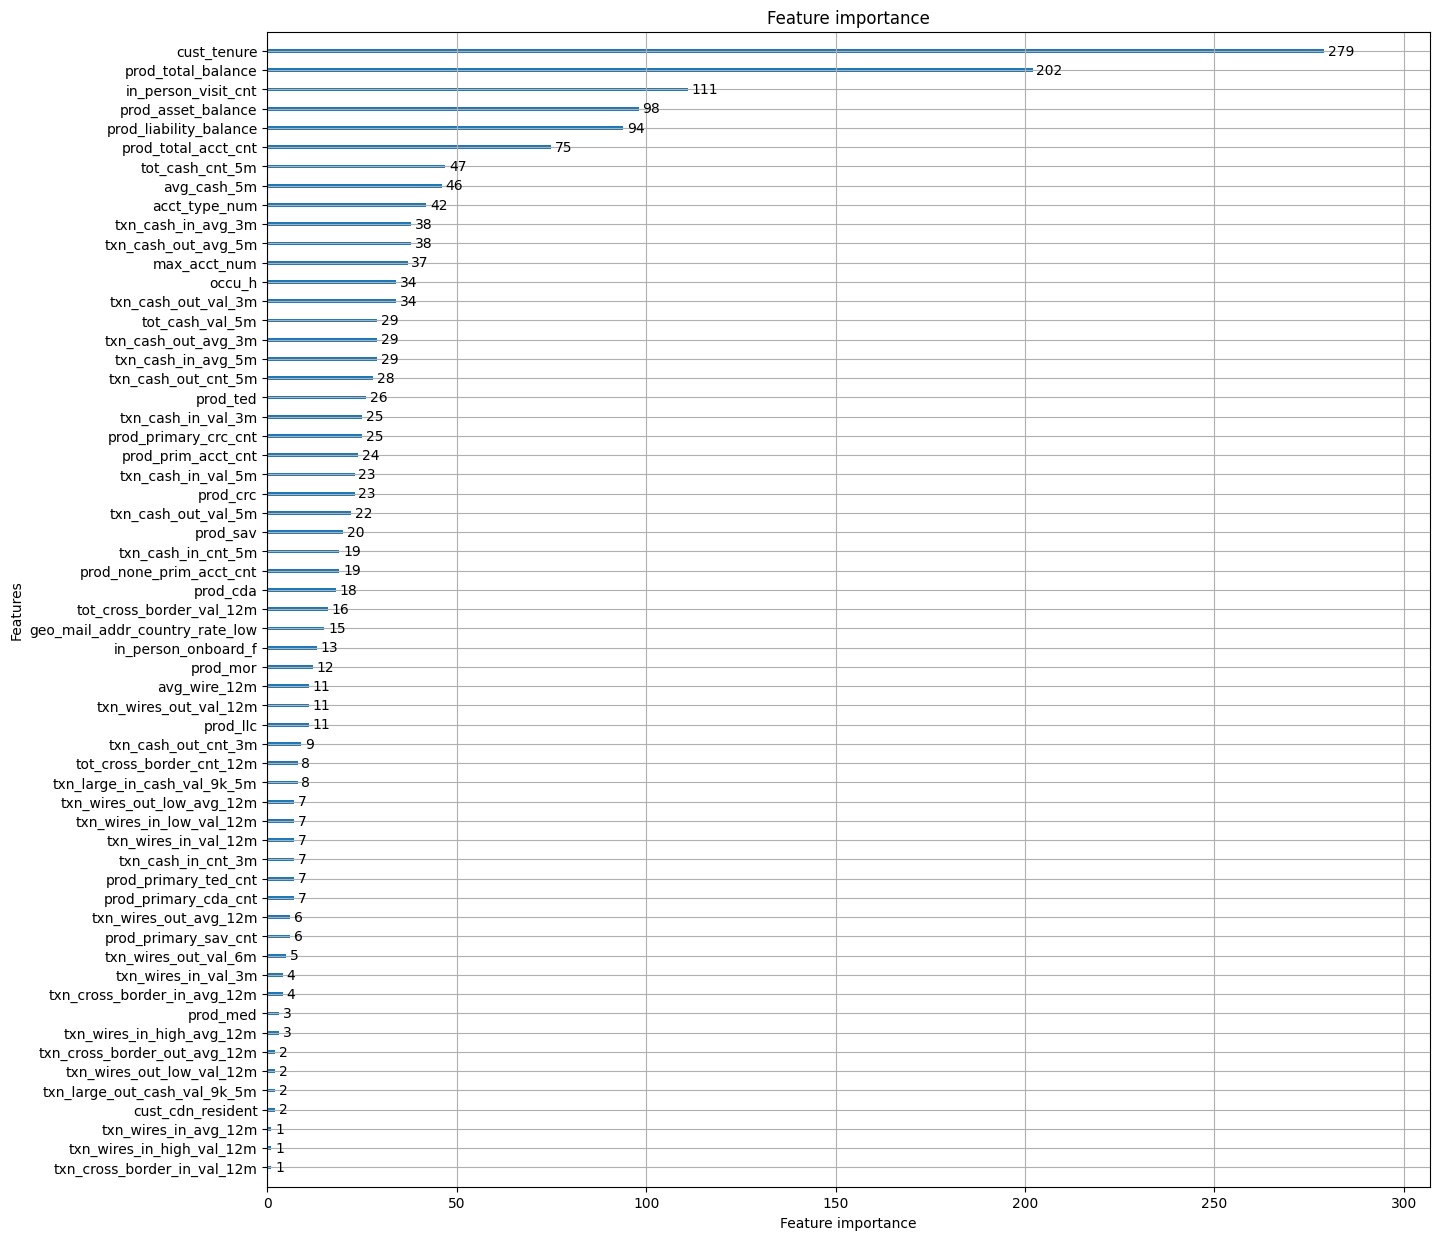

In [22]:
#plot feature importance
import matplotlib.pyplot as plt
lgb.plot_importance(gbm, figsize=(15, 15))
plt.show()

In [24]:
# see AUC in test set
from sklearn.metrics import roc_auc_score
y_pred = gbm.predict(test.drop(['rating','cust_id_masked'], axis=1), num_iteration=gbm.best_iteration)
print('The AUC of prediction is:', roc_auc_score(test['rating'], y_pred))

The AUC of prediction is: 0.8035714285714286


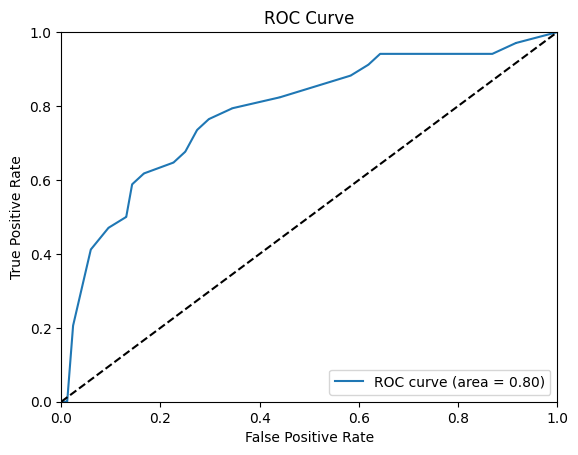

In [28]:
#plot auc plot with 45 degree line
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(test['rating'], y_pred)
# apply exponential smoothing to tpr
from statsmodels.tsa.holtwinters import ExponentialSmoothing
tpr = ExponentialSmoothing(tpr).fit().fittedvalues
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(test['rating'], y_pred))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()